In [53]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import mlab
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
import scipy.optimize as opt
import itertools

In [54]:
# Import data
data1 = pd.read_csv('./Sunrise_Blvd_MVDS_data_NoIncidents.csv', sep=',')

#Filtering detectors
selected_detectors = data1['DETECTOR_ID'].isin([11, 15])
data1 = data1[selected_detectors]

In [55]:
#CLeaning null values and outliers
data = data1.dropna()
data = data[(data.TOTAL_VOL <= 800)]

# Creating column with the volume per lane
data['vol_lane'] = (data['TOTAL_VOL'] / 3) * 4
data['density'] = (5280*data['AVG_OCC']) / (100*(15+6))
data['TIMESTAMP'] = pd.to_datetime(data['DATE_TIME'])
data2 = data.drop(['DATE_TIME', 'DETECT_TIME', 'DETECT_DATE', 'TOTAL_VOL', 'AVG_TT', 'AVG_OCC'], axis = 1)
dir_num = {'EB': 1,'WB': 2}
data2['DIR_NUM'] = data2['DIRECTION']
data2.DIR_NUM = [dir_num[item] for item in data2.DIR_NUM]
data2['DAY_WEEK'] = data2['TIMESTAMP'].dt.dayofweek
data2['TIME_DAY'] = data2['TIMESTAMP'].dt.time

data2['hours'] = data2['TIMESTAMP'].dt.hour
data2['minutes'] = data2['TIMESTAMP'].dt.minute
data2['min_dec'] = data2['minutes'] / 60
data2['TIME_DEC'] = data2['hours'] + data2['min_dec']
data2 = data2.drop(['hours', 'minutes', 'min_dec'], axis = 1)

data2 = data2[['TIMESTAMP', 'DAY_WEEK', 'TIME_DAY', 'TIME_DEC', 'DIR_NUM','DIRECTION','DETECTOR_ID',
               'density', 'AVG_SPEED', 'vol_lane']]

In [56]:
# creating a data frame for direction
data_EB = data2[(data2.DIRECTION == 'EB')]

In [57]:
# Separating fata by detector
data_selected = data_EB[(data_EB.DETECTOR_ID == 11)]

In [58]:
data_selected[:2]

,TIMESTAMP,DAY_WEEK,TIME_DAY,TIME_DEC,DIR_NUM,DIRECTION,DETECTOR_ID,density,AVG_SPEED,vol_lane
11142,2015-06-01 07:00:00,0,07:00:00,7.00,1,EB,11,15.085714,39.666667,489.333333
11143,2015-06-01 07:15:00,0,07:15:00,7.25,1,EB,11,18.438095,38.000000,568.000000


## Clustering

In [60]:
features = ['AVG_SPEED', 'vol_lane', 'density']
select_EB11_std = stats.zscore(data_selected[features])

kmeans_avg = KMeans(n_clusters=3, random_state=0).fit(select_EB11_std)
labels = kmeans_avg.labels_
kmeans_avg.cluster_centers_

data_selected['clusters'] = labels
features.extend(['clusters'])
data_selected[features].groupby(['clusters']).mean()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,AVG_SPEED,vol_lane,density
clusters,,,
0,35.779959,671.377613,26.269488
1,25.733497,788.876051,48.518274
2,42.652896,400.078305,11.613788


<IPython.core.display.Javascript object>


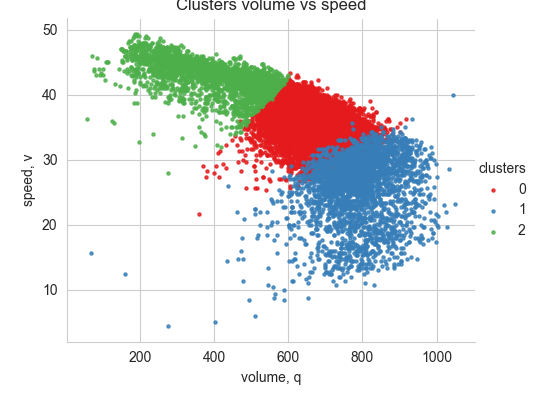

Text(36.48825784063143, 0.5, 'speed, v')

In [62]:
sns.lmplot('vol_lane', 'AVG_SPEED', data=data_selected, fit_reg=False, height=4, aspect=1.2, hue="clusters", palette="Set1", 
           #markers=['o', '.', '+', '^']) 
           scatter_kws={"marker": "D", "s": 5})

sns.set_style("whitegrid")
plt.title('Clusters volume vs speed')
plt.xlabel('volume, q')
plt.ylabel('speed, v')

In [63]:
data_selected['clust'] = data_selected['clusters']

right_clusters = {2:0, 0:1, 1:2} 
data_selected.clust = [right_clusters[item] for item in data_selected.clust]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Classification

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [65]:
data_selected[:2]

,TIMESTAMP,DAY_WEEK,TIME_DAY,TIME_DEC,DIR_NUM,DIRECTION,DETECTOR_ID,density,AVG_SPEED,vol_lane,clusters,clust
11142,2015-06-01 07:00:00,0,07:00:00,7.00,1,EB,11,15.085714,39.666667,489.333333,2,0
11143,2015-06-01 07:15:00,0,07:15:00,7.25,1,EB,11,18.438095,38.000000,568.000000,0,1


In [66]:
data_selected.shape

(14667, 12)

First aassign the prediction labels for each example in the dataset

In [67]:
#Extract list for prediction labels @ 15 min
dfs_all =data_selected.copy()
clust_15 = dfs_all.iloc[1:,11:12].values.tolist()


# #Add extracted labels to the df 
dfs_all.reset_index(drop=True, inplace=True)
dfs_all = pd.concat([dfs_all, pd.DataFrame(clust_15, columns = ['clust_15'])], axis=1)
dfs_all = dfs_all.dropna()

In [68]:
dfs_all.shape

(14666, 13)

In [69]:
dfs_all[:10]

,TIMESTAMP,DAY_WEEK,TIME_DAY,TIME_DEC,DIR_NUM,DIRECTION,DETECTOR_ID,density,AVG_SPEED,vol_lane,clusters,clust,clust_15
0,2015-06-01 07:00:00,0,07:00:00,7.00,1,EB,11,15.085714,39.666667,489.333333,2,0,1.0
1,2015-06-01 07:15:00,0,07:15:00,7.25,1,EB,11,18.438095,38.000000,568.000000,0,1,1.0
2,2015-06-01 07:30:00,0,07:30:00,7.50,1,EB,11,26.819048,34.333333,681.333333,0,1,2.0
3,2015-06-01 07:45:00,0,07:45:00,7.75,1,EB,11,48.609524,24.666667,744.000000,1,2,2.0
4,2015-06-01 08:00:00,0,08:00:00,8.00,1,EB,11,72.076190,16.666667,812.000000,1,2,2.0
5,2015-06-01 08:15:00,0,08:15:00,8.25,1,EB,11,46.095238,30.666667,813.333333,1,2,2.0
6,2015-06-01 08:30:00,0,08:30:00,8.50,1,EB,11,41.904762,31.333333,874.666667,1,2,2.0
7,2015-06-01 08:45:00,0,08:45:00,8.75,1,EB,11,50.285714,30.000000,942.666667,1,2,2.0
8,2015-06-01 09:00:00,0,09:00:00,9.00,1,EB,11,45.257143,32.666667,876.000000,1,2,1.0
9,2015-06-01 09:15:00,0,09:15:00,9.25,1,EB,11,34.361905,36.000000,809.333333,0,1,1.0


In [70]:
y = dfs_all[['clust_15']].copy()

features = ['DAY_WEEK', 'TIME_DEC', 'density', 'AVG_SPEED', 'vol_lane', 'clust']
X = dfs_all[features].copy()


## Decision Tree

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=324)

traff_state_classifier = DecisionTreeClassifier(criterion='gini', min_samples_split=100, min_samples_leaf = 50, splitter='best', max_depth=3, max_leaf_nodes=10, random_state=5,min_impurity_split = 0.3)
traff_state_classifier.fit(X_train, y_train)

predictions = traff_state_classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


0.7613636363636364

In [72]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

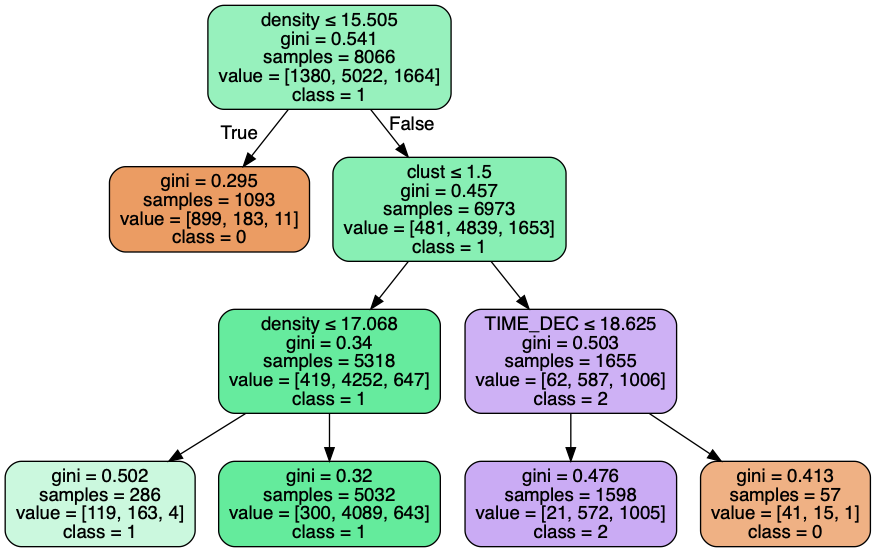

In [73]:
dot_data = StringIO()
export_graphviz(traff_state_classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('traffic_state.png')
Image(graph.create_png())

In [74]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_pred = predictions),
    columns=['Pred_0', 'Pred_1', 'Pred_2'],
    index=['True_0', 'True_1', 'True_2']
)

,Pred_0,Pred_1,Pred_2
True_0,705,381,19
True_1,162,3505,480
True_2,15,518,815


In [75]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test, predictions, average='macro')

(0.738476884124143, 0.6959325832557003, 0.7139070677528917, None)

In [76]:
#import scikitplot as skplt
#y_probas = traff_state_classifier.predict_proba(X_test)
#skplt.metrics.plot_roc(y_test, y_probas, plot_macro=False, figsize=(7.1,5.6))
#plt.savefig('ROC_Dec.png')

#plt.show()

In [77]:
#skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(7.1,5.6))
#plt.savefig('PR_Dec.png')
#plt.show()

## Random Forest

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf=RandomForestClassifier(n_estimators=200)#,criterion='gini',min_impurity_split = 0.45, min_samples_split=200, min_samples_leaf = 100,  max_depth=5, max_leaf_nodes=40, random_state=5)
rf.fit(X_train,y_train)
y_predrf=rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_predrf))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Accuracy: 0.7718181818181818


In [79]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred = y_predrf),
    columns=['Pred_0', 'Pred_1', 'Pred_2'],
    index=['True_0', 'True_1', 'True_2']
)

,Pred_0,Pred_1,Pred_2
True_0,753,331,21
True_1,186,3609,352
True_2,17,599,732


In [80]:
precision_recall_fscore_support(y_test, y_predrf, average='macro')

(0.7484031325125385, 0.6982474444678236, 0.7195086225671442, None)

In [81]:
list(zip(X_train, rf.feature_importances_))

[('DAY_WEEK', 0.06188508058051189),
 ('TIME_DEC', 0.1738722851453287),
 ('density', 0.21241152430463495),
 ('AVG_SPEED', 0.19373347842140906),
 ('vol_lane', 0.24044820307464232),
 ('clust', 0.11764942847347305)]

<IPython.core.display.Javascript object>


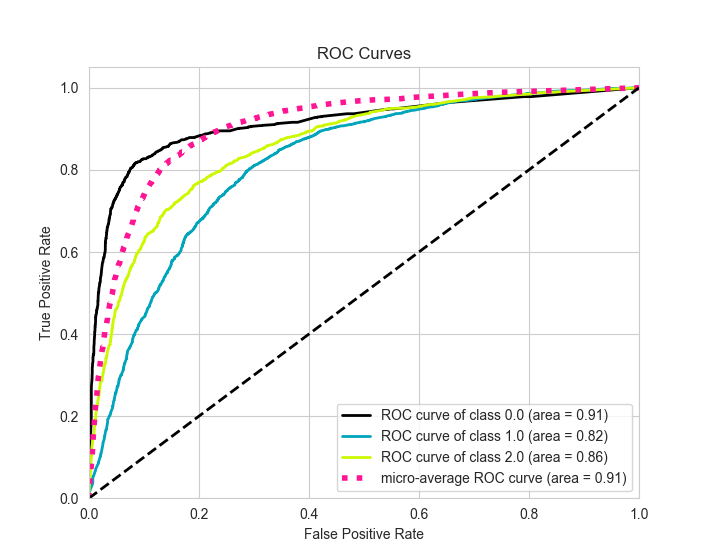

In [82]:
import scikitplot as skplt
y_probas = rf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, plot_macro=False, figsize=(7.1,5.6))
plt.savefig('ROC_EB11.png')

plt.show()

<IPython.core.display.Javascript object>


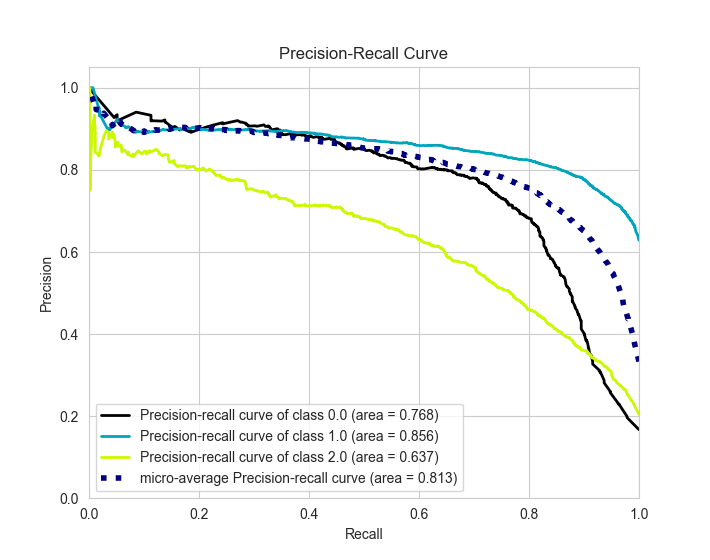

In [83]:
skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(7.1,5.6))
plt.savefig('PR_EB11.png')
plt.show()

## Multinomial Logit Model

In [84]:
from sklearn import linear_model
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train,y_train)
y_predml=mul_lr.predict(X_test)

print ("Multinomial Logistic regression Train Accuracy ::", metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print ("Multinomial Logistic regression Test Accuracy ::", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Multinomial Logistic regression Train Accuracy :: 0.7640714108604016
Multinomial Logistic regression Test Accuracy :: 0.7578787878787879


In [85]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred = y_predml),
    columns=['Pred_0', 'Pred_1', 'Pred_2'],
    index=['True_0', 'True_1', 'True_2']
)

,Pred_0,Pred_1,Pred_2
True_0,677,387,41
True_1,166,3732,249
True_2,18,737,593


In [86]:
precision_recall_fscore_support(y_test, y_predml, average='macro')

(0.742134319131679, 0.6508361070115845, 0.6831217323069042, None)

## Naive Bayes

In [87]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)
y_prednb=nb.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_prednb))

Accuracy: 0.7515151515151515


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred = y_prednb),
    columns=['Pred_0', 'Pred_1', 'Pred_2'],
    index=['True_0', 'True_1', 'True_2']
)

,Pred_0,Pred_1,Pred_2
True_0,768,285,52
True_1,282,3376,489
True_2,21,511,816


In [89]:
precision_recall_fscore_support(y_test, y_prednb, average='macro')

(0.7092058362501482, 0.7048154466600245, 0.7069485129296806, None)

## Stochastic Gradient Descent

In [90]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = "hinge",shuffle =True, random_state = 5)
sgd.fit(X_train,y_train)
y_predsgd=sgd.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_predsgd))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7231818181818181


In [91]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred = y_predsgd),
    columns=['Pred_0', 'Pred_1', 'Pred_2'],
    index=['True_0', 'True_1', 'True_2']
)

,Pred_0,Pred_1,Pred_2
True_0,357,728,20
True_1,29,3987,131
True_2,6,913,429


In [92]:
precision_recall_fscore_support(y_test, y_predsgd, average='macro')

(0.7862638776560548, 0.5342480245631785, 0.5792430434689743, None)

## K-Nearest Neighbours

In [93]:
# K nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train,y_train)
y_predknn=knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_predknn))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


Accuracy: 0.7525757575757576


In [94]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred = y_predknn),
    columns=['Pred_0', 'Pred_1', 'Pred_2'],
    index=['True_0', 'True_1', 'True_2']
)

,Pred_0,Pred_1,Pred_2
True_0,675,390,40
True_1,176,3690,281
True_2,17,729,602


In [95]:
precision_recall_fscore_support(y_test, y_predknn, average='macro')

(0.7323940264440711, 0.6490823736386241, 0.6794762367471939, None)